In [21]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from shared import Db, Fn

from main.ai import ai_setups, zero_setup
from main.data import Mol, data
from main.tree import JsonTree, Tree, TreeTypes
from main.types import AiInput, Setup
from main.score import Score
from main.stats import score_transformer
from main.utils import fn_txt

from IPython.display import display, HTML
from typing import Any

import numpy as np
import pandas
import tabulate

from sklearn import metrics


import matplotlib.pyplot as plt


def scatter_plot(pairs_per_plot: list[list[tuple[Any, Any, str]]]):
    fig, axs = plt.subplots(nrows=1, ncols=len(pairs_per_plot), figsize=(16, 3))
    fig.set_dpi(300)
    for i, pairs in enumerate(pairs_per_plot):
        xs = [x for x, _y, _ in pairs]
        ys = [y for _x, y, _ in pairs]
        axs[i].scatter(xs, ys, s=5, linewidths=1)
        axs[i].set_title(pairs[0][2])
    plt.show()


def get_stats(mol: Mol):
    ai_input: AiInput = {"smiles": mol.smiles, "setup": zero_setup}
    json_tree = db.read(["ai_postprocess", ai_input], JsonTree)
    assert json_tree
    tree = Tree(json_tree)
    assert len(tree.expandable) == 1
    assert len(tree.in_stock) == 0
    return tree.expandable[0].score, tree.type, tree.stats()

filters: list[Fn[TreeTypes, bool]] = [
    lambda _type: True,
    lambda type: type == "internal",
    lambda type: type == "not_solved"
]

USE_MF = True    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Check how many molecules has correctly found synthesis route

with Db("db_modified", True) as db:
    mols = data()
    tree_stats = [get_stats(mol) for mol in mols]
    synthesis_found = np.array([ts[1] in ["solved", "internal"] for ts in tree_stats])
    synthesable = np.array([m.synthesable for m in mols])
    correctly_found = np.logical_and(synthesis_found, synthesable)
    correctly_not_found = np.logical_and(np.logical_not(synthesis_found),
                                         np.logical_not(synthesable))
    print("Number of correctly found synthesis", np.sum(correctly_found))
    print("Number of correctly not found synthesis", np.sum(correctly_not_found))
    print("Accuracy:", np.sum(np.logical_or(correctly_found, correctly_not_found) / len(tree_stats)))
    print("Precision:", np.sum(correctly_found) / np.sum(synthesis_found))
    print("Recall:", np.sum(correctly_found) / np.sum(synthesable))

Number of correctly found synthesis 20
Number of correctly not found synthesis 3
Accuracy: 0.4693877551020408
Precision: 0.9090909090909091
Recall: 0.45454545454545453


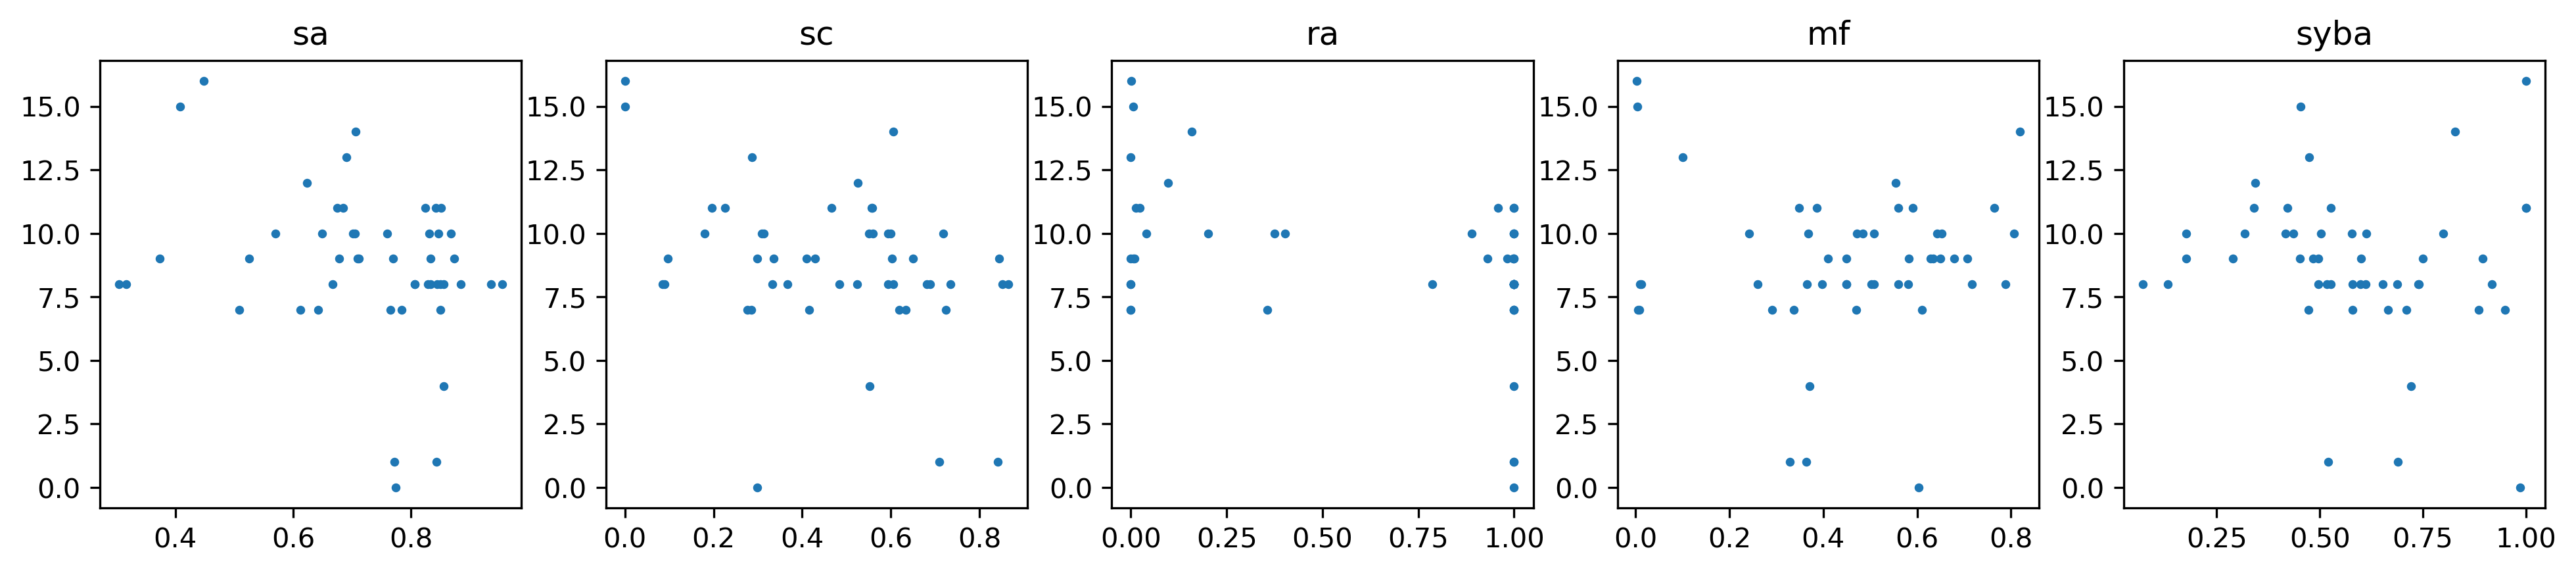

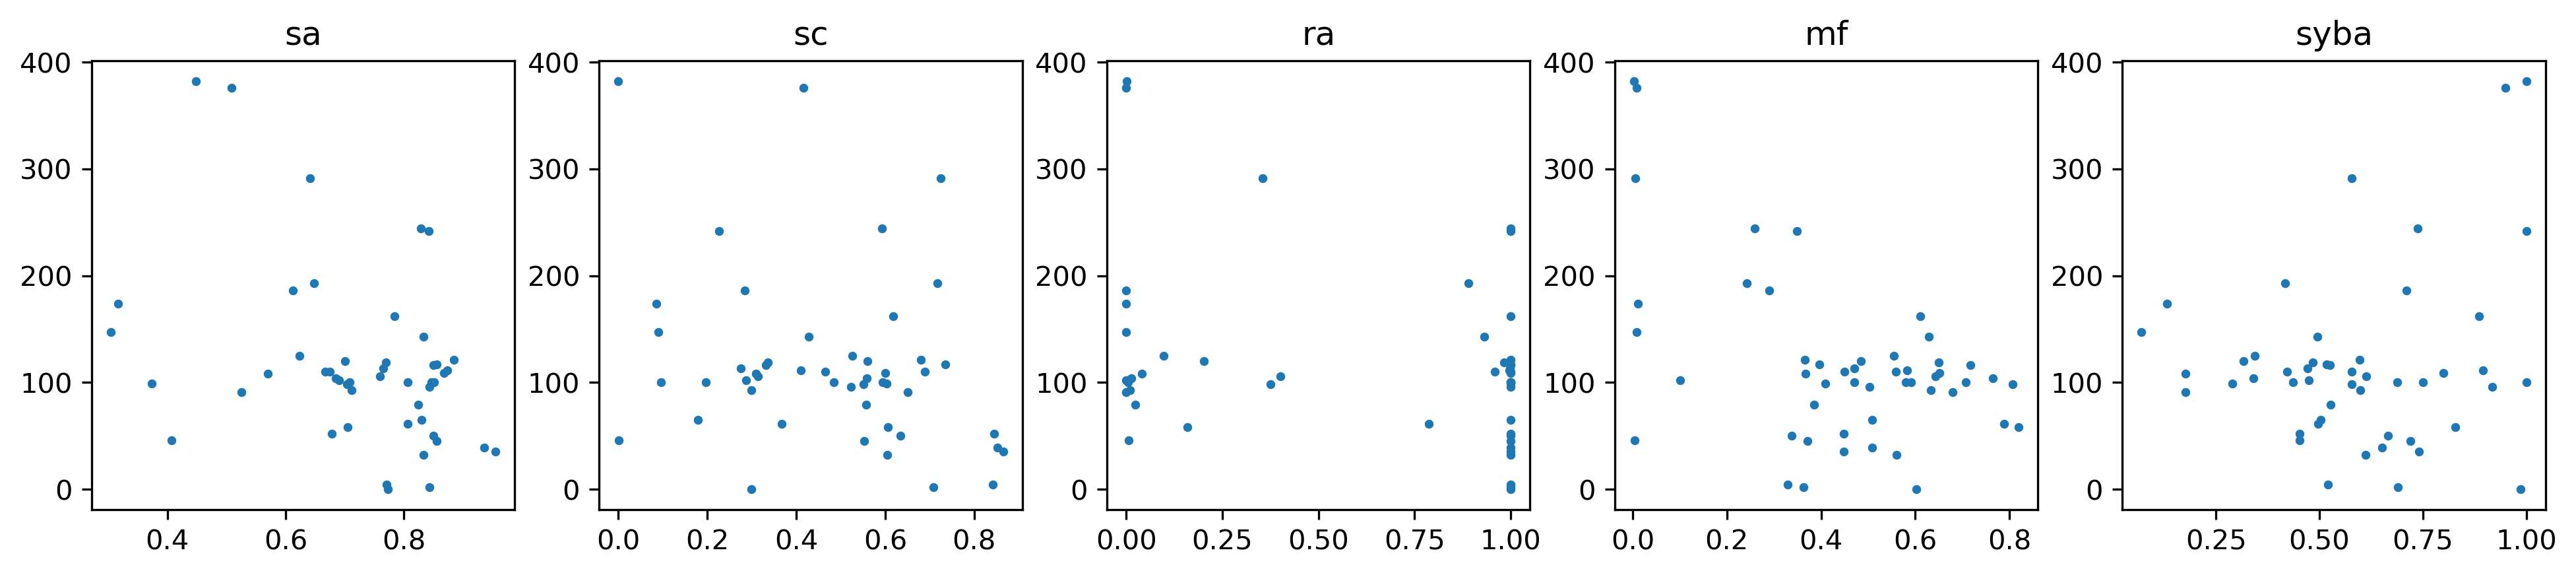

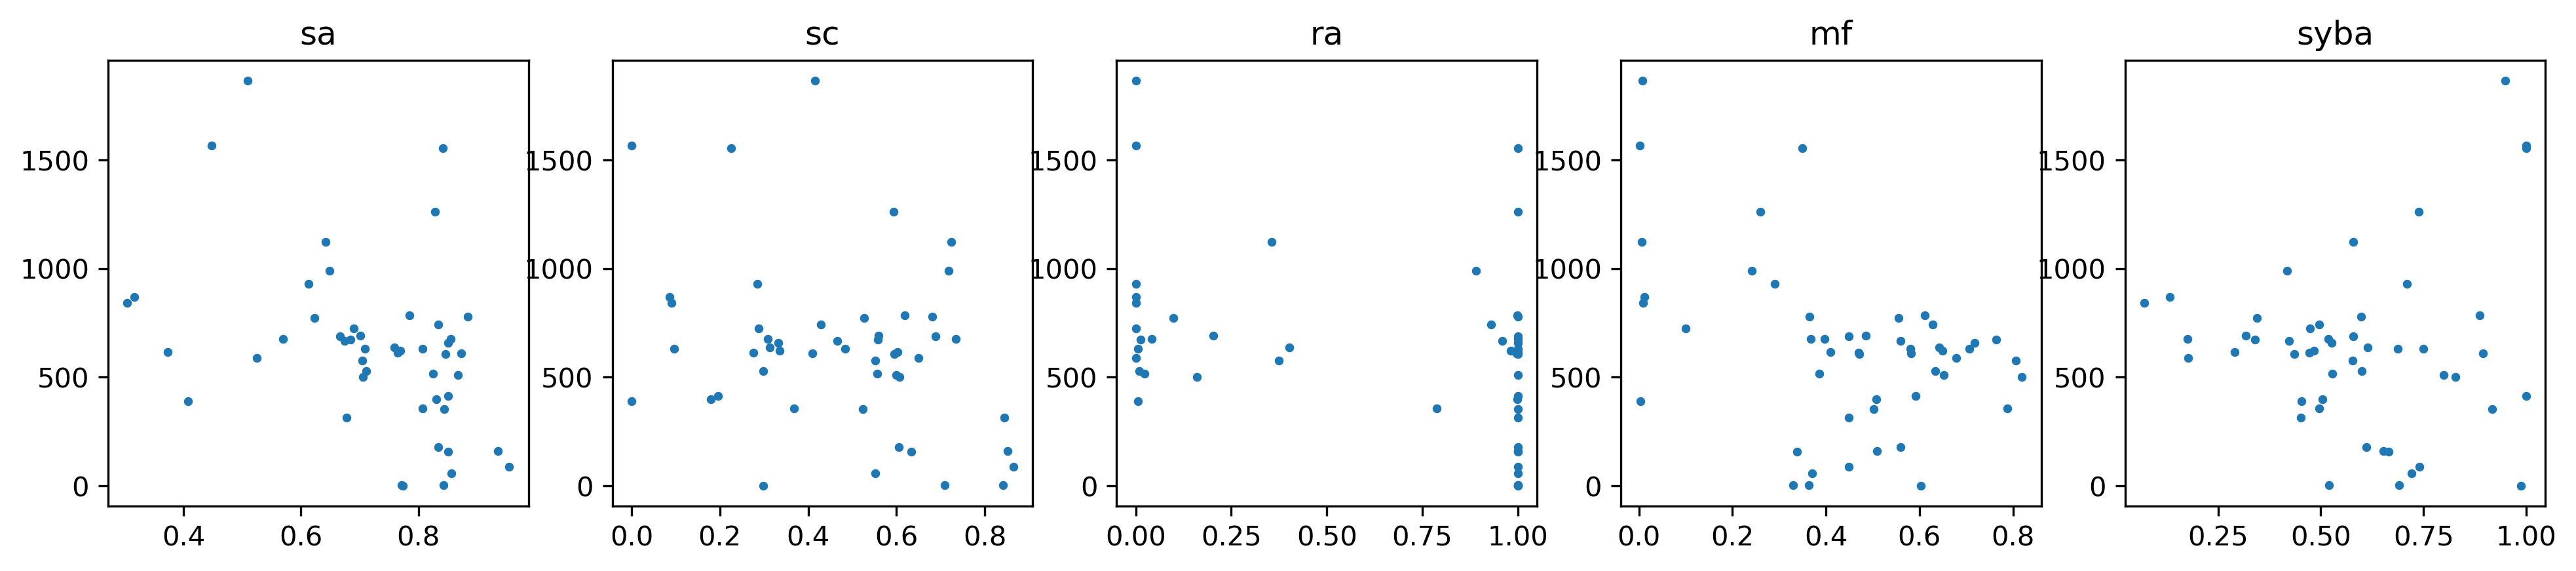

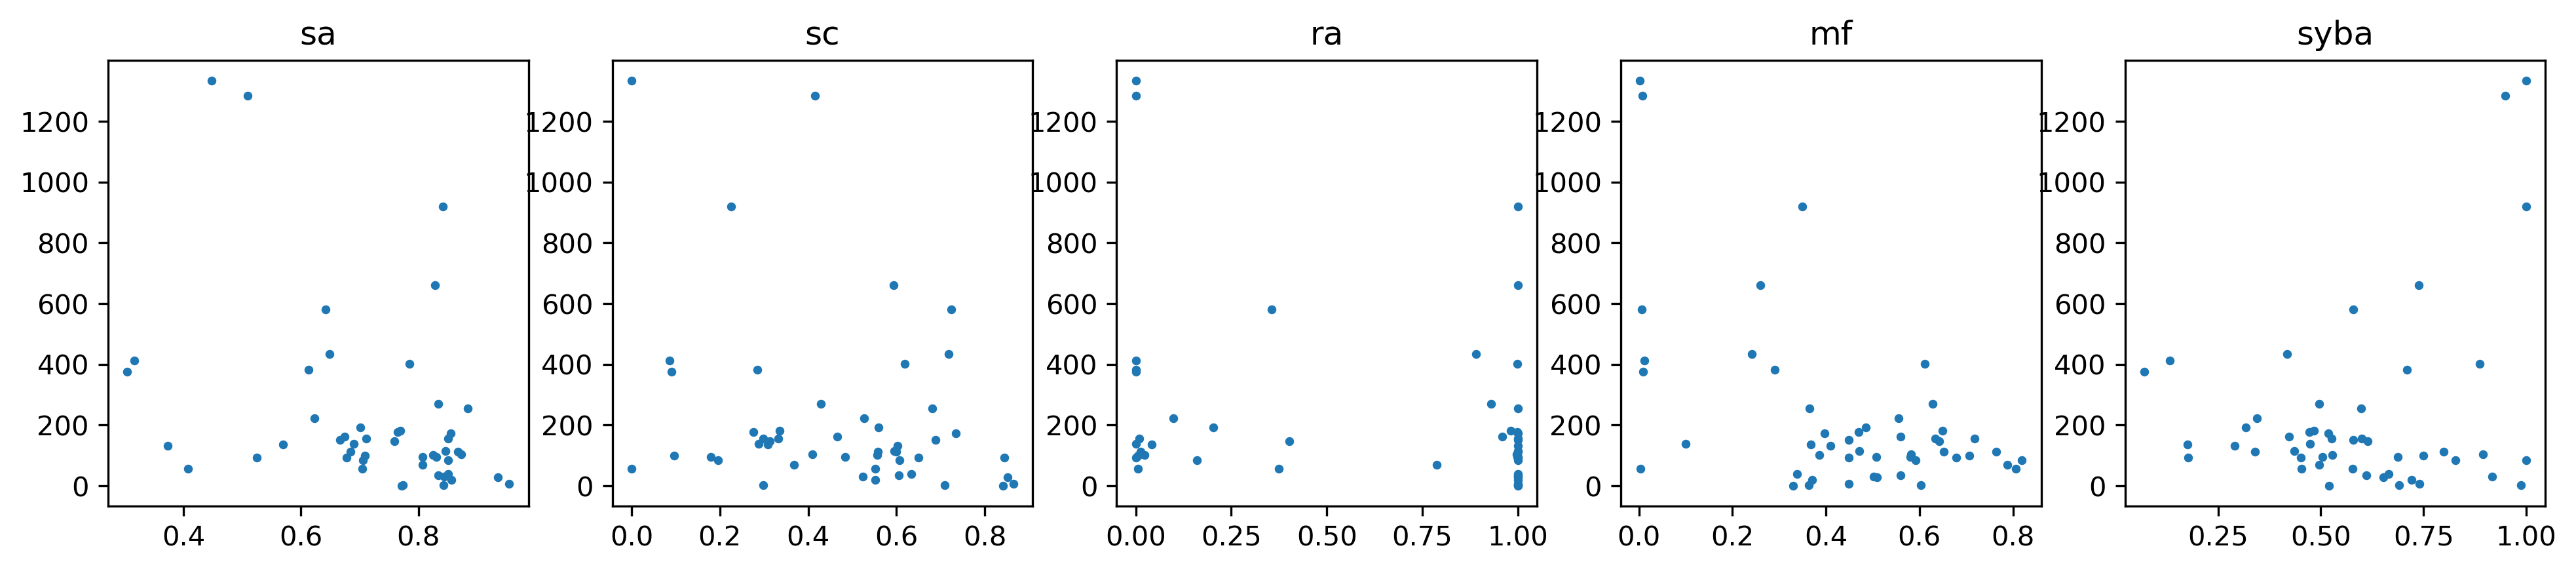

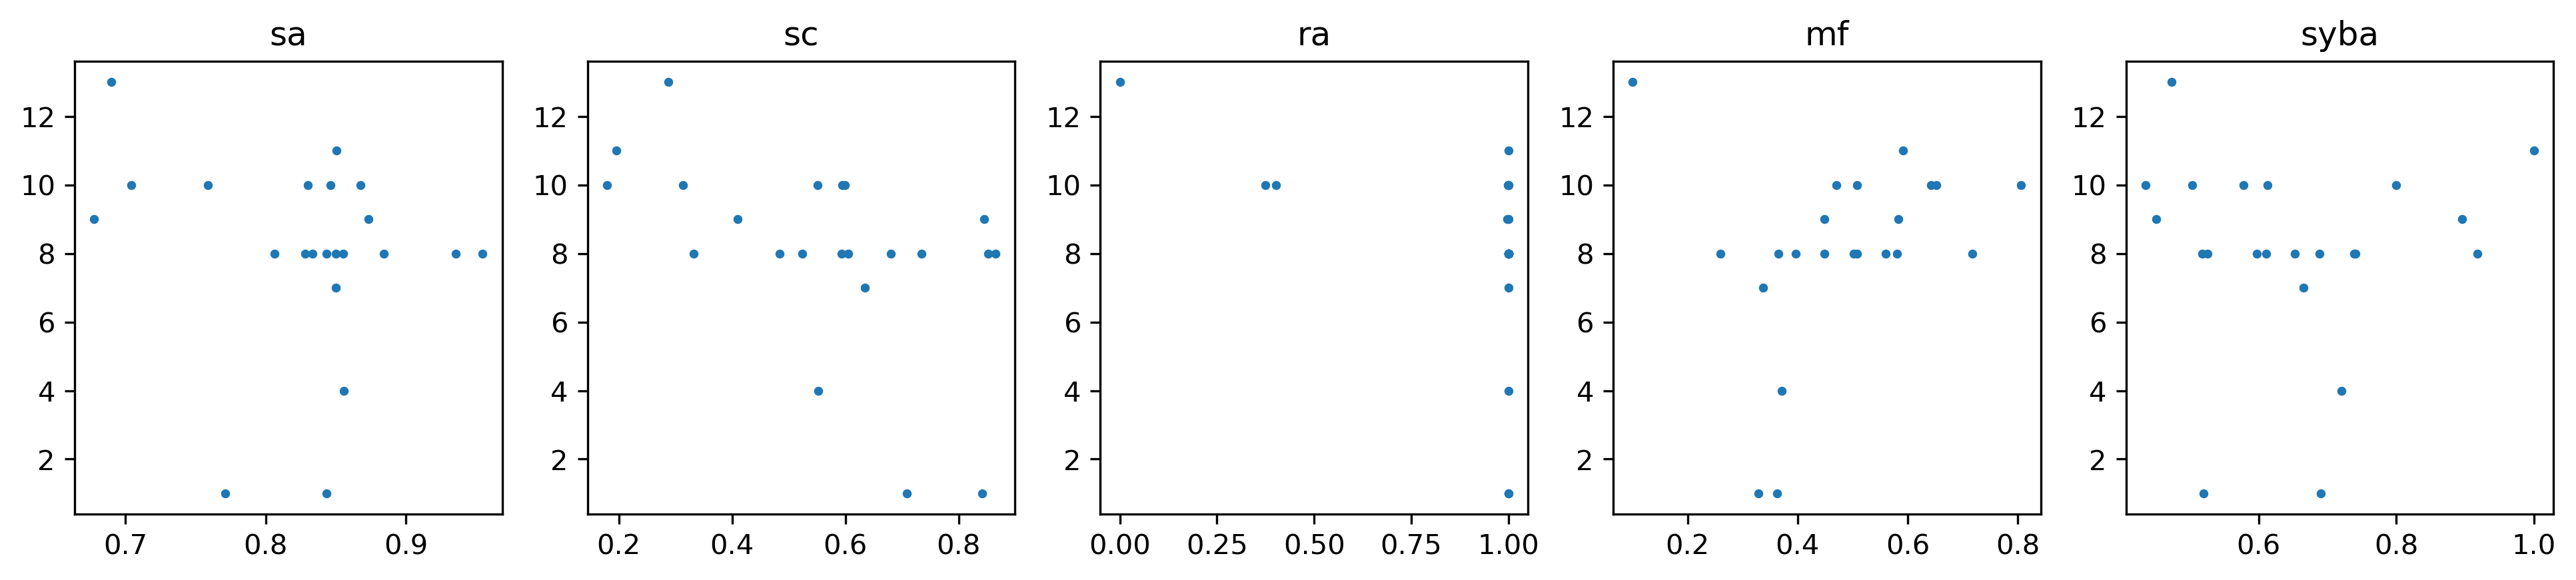

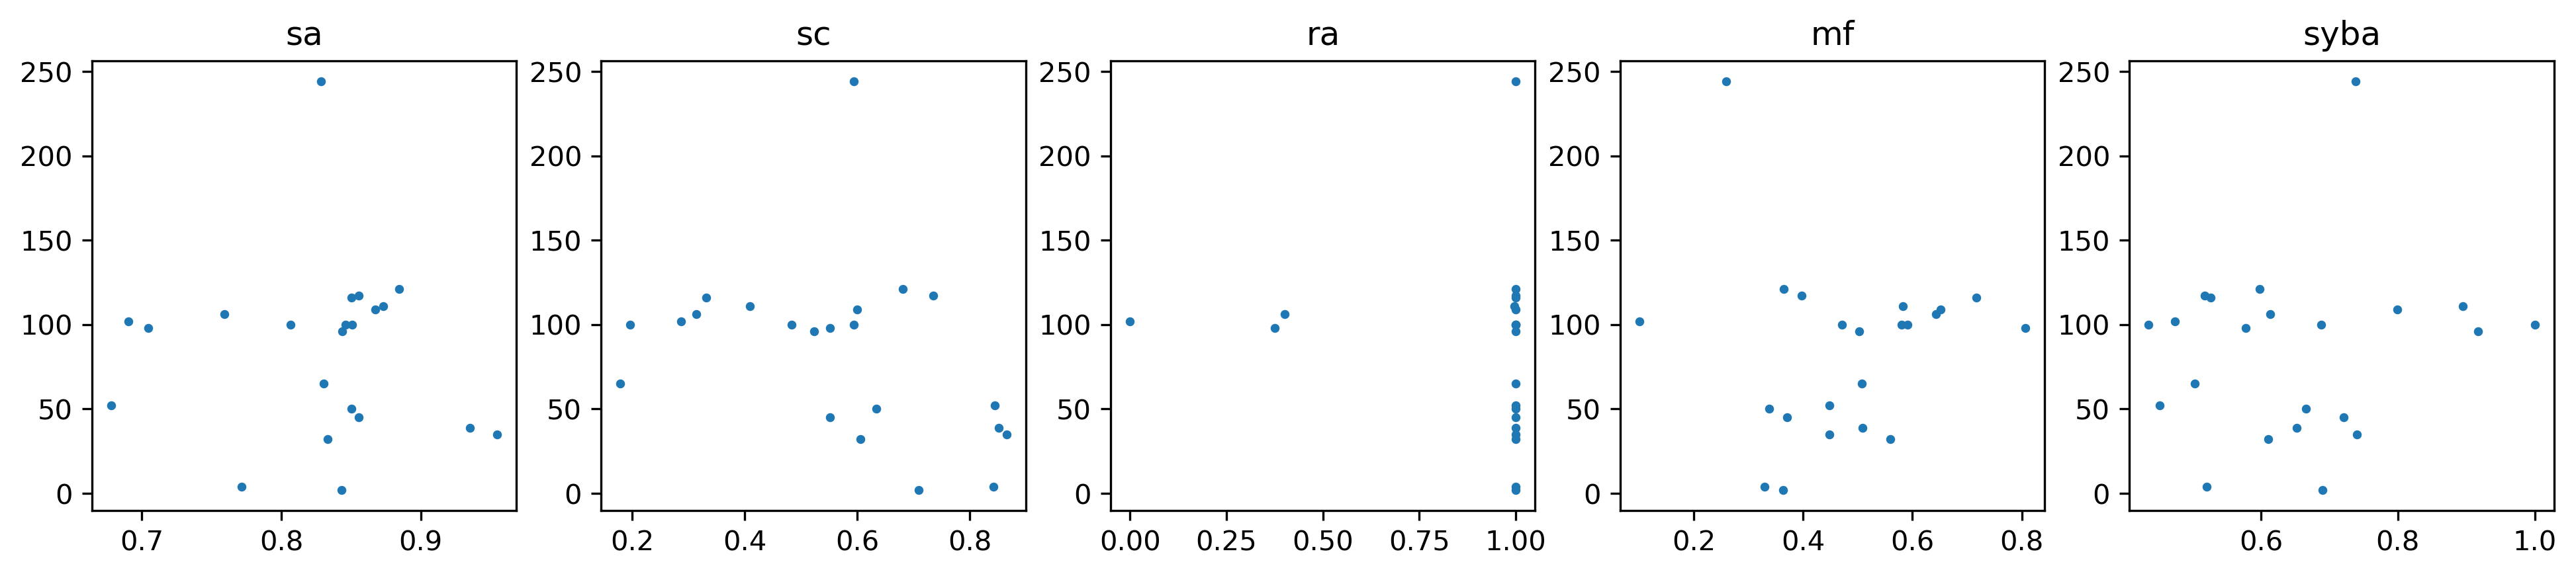

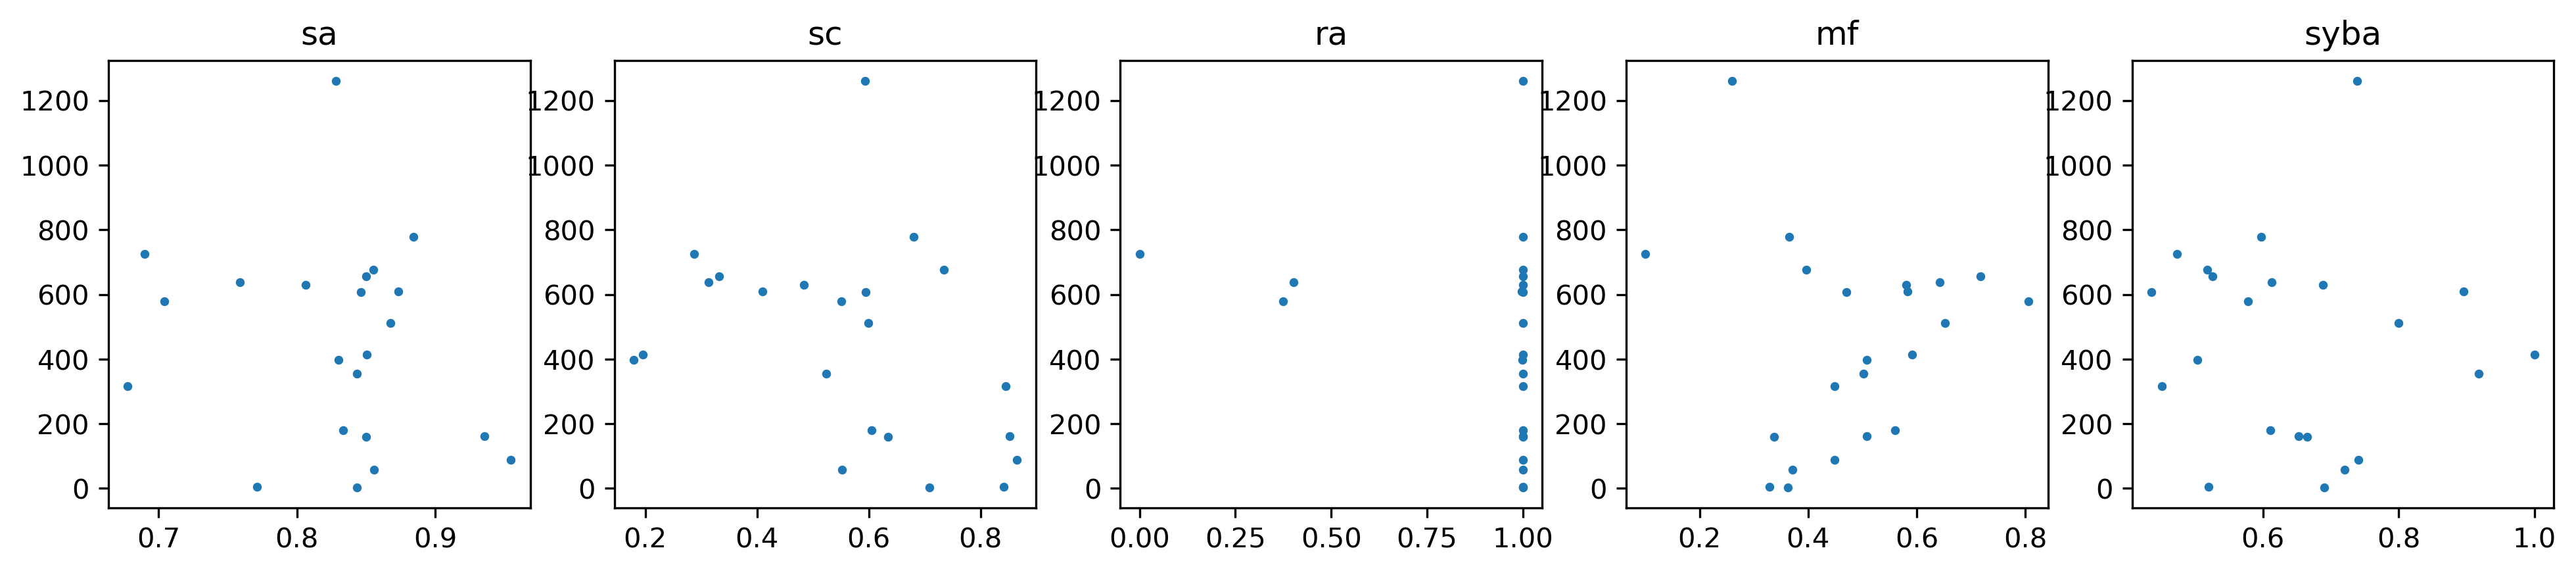

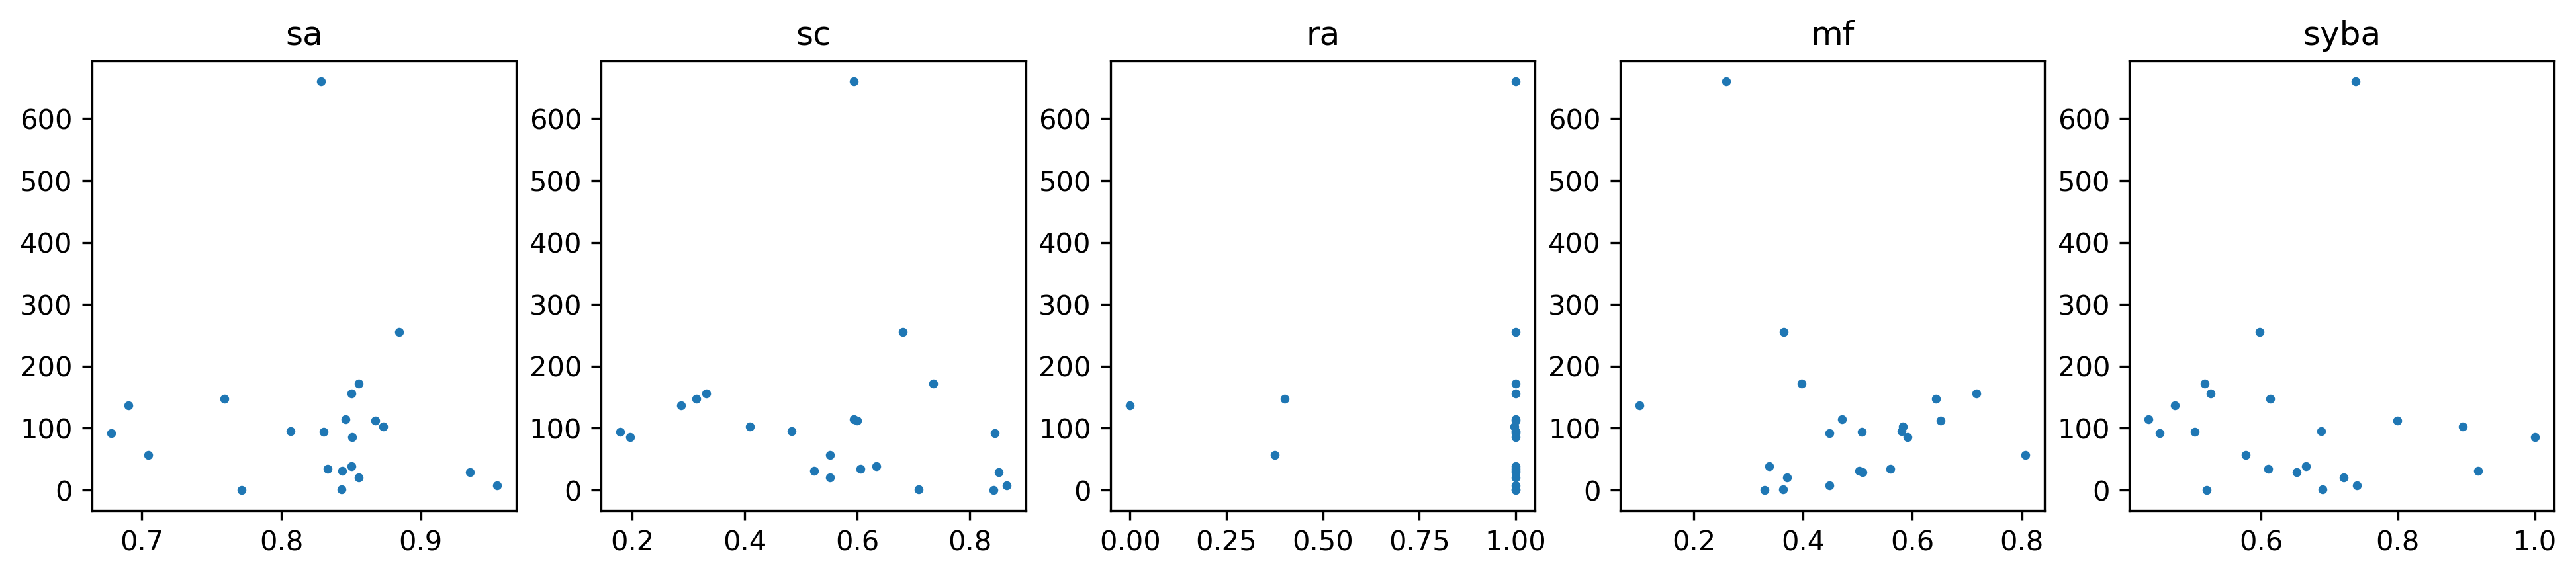

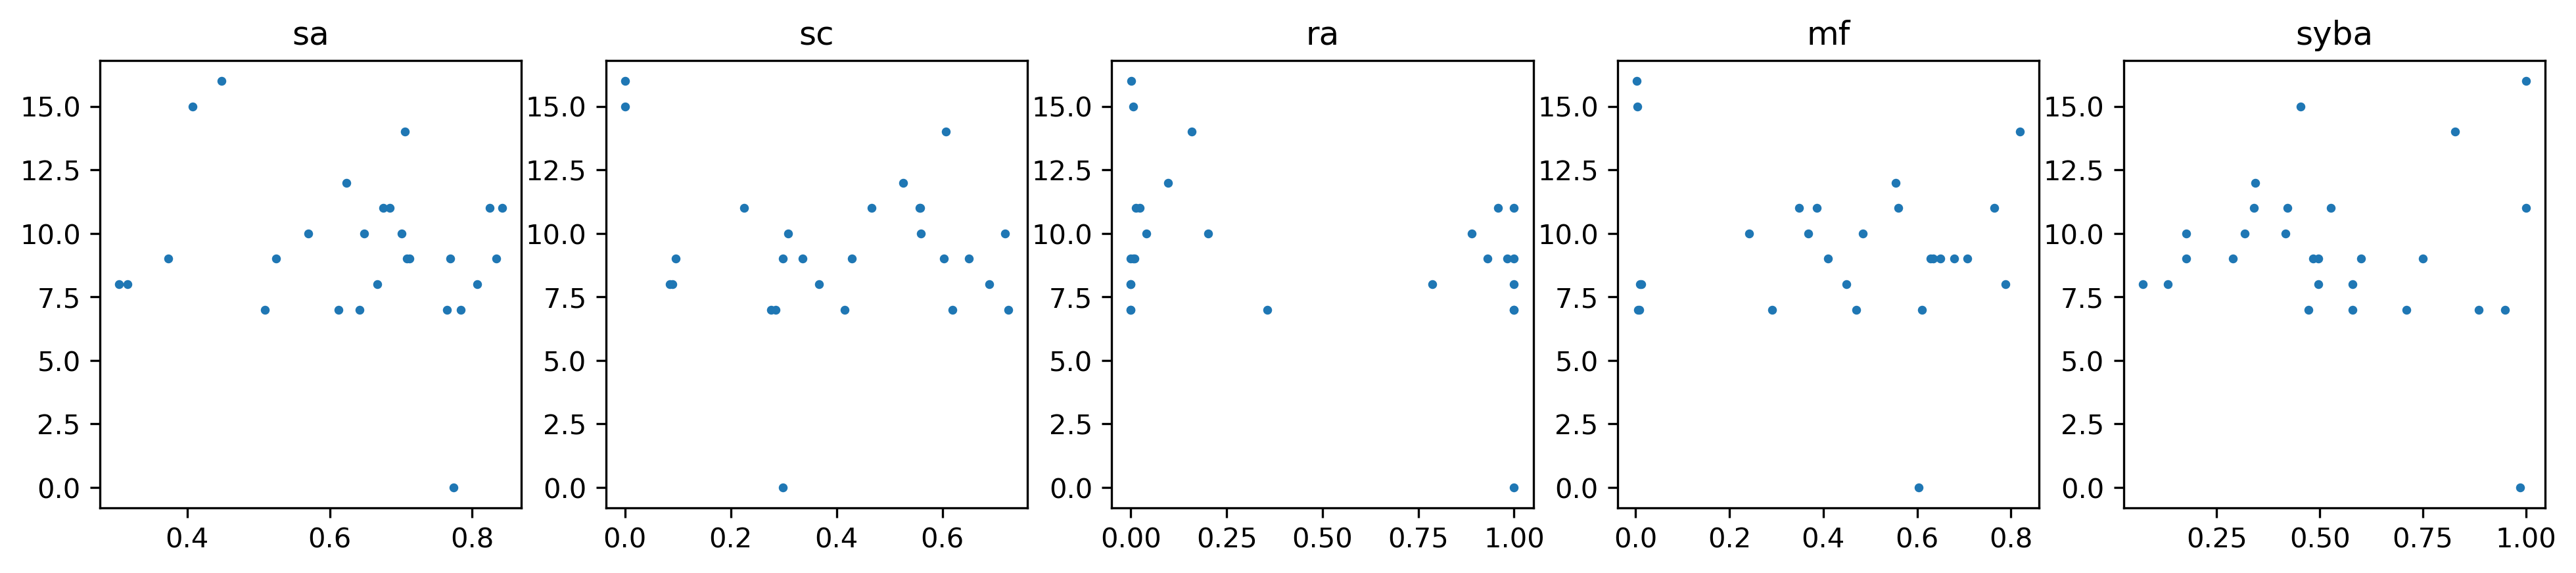

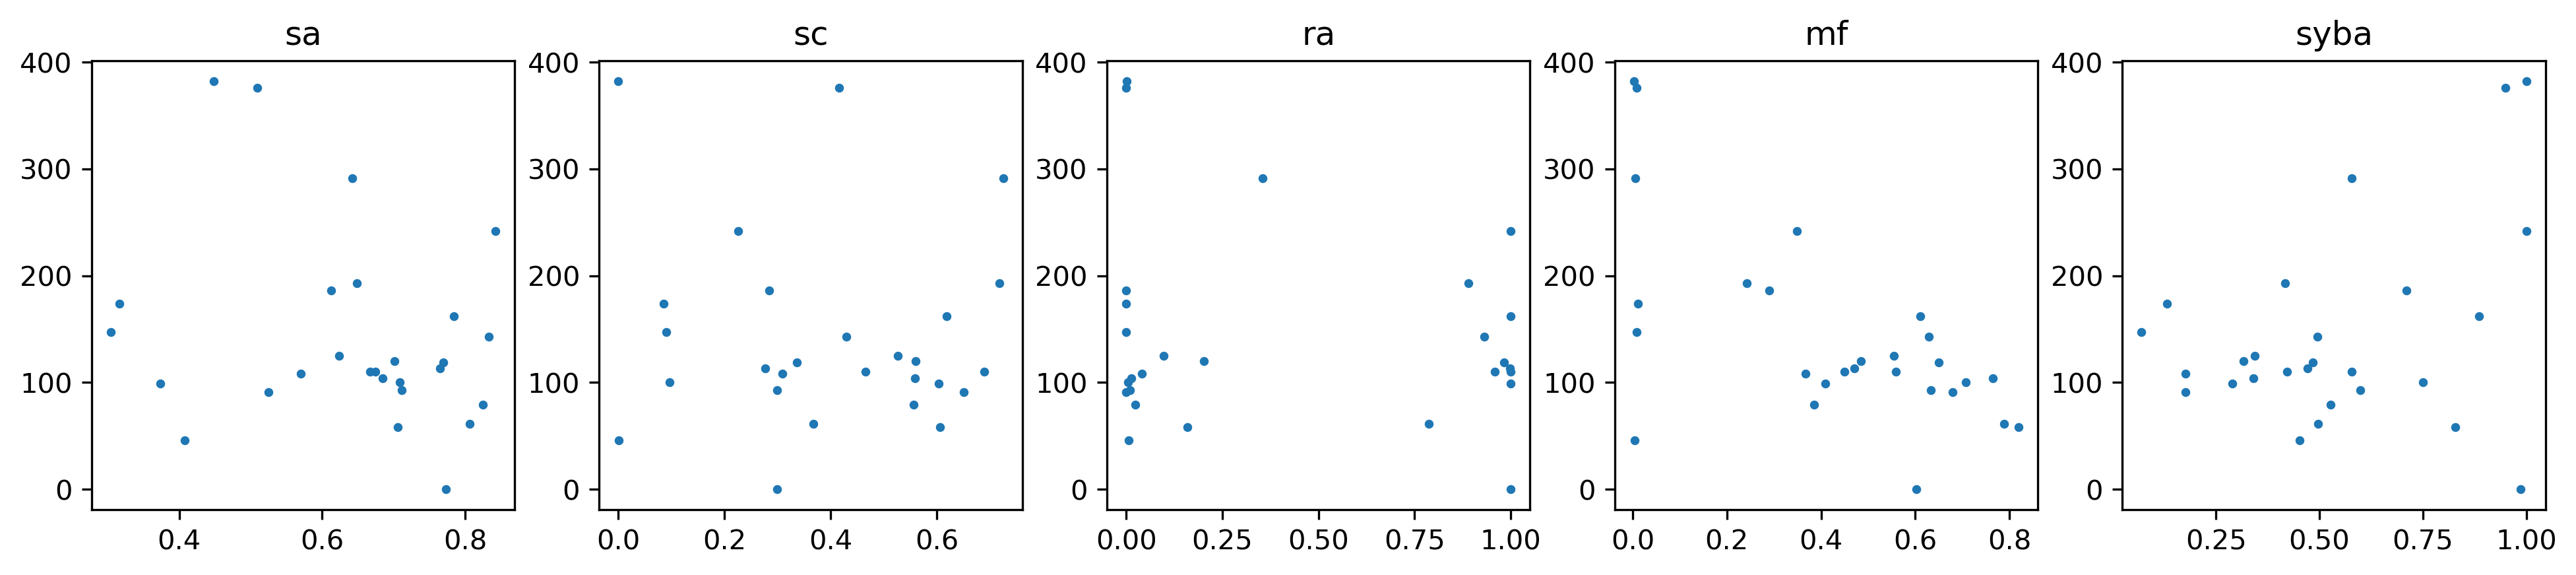

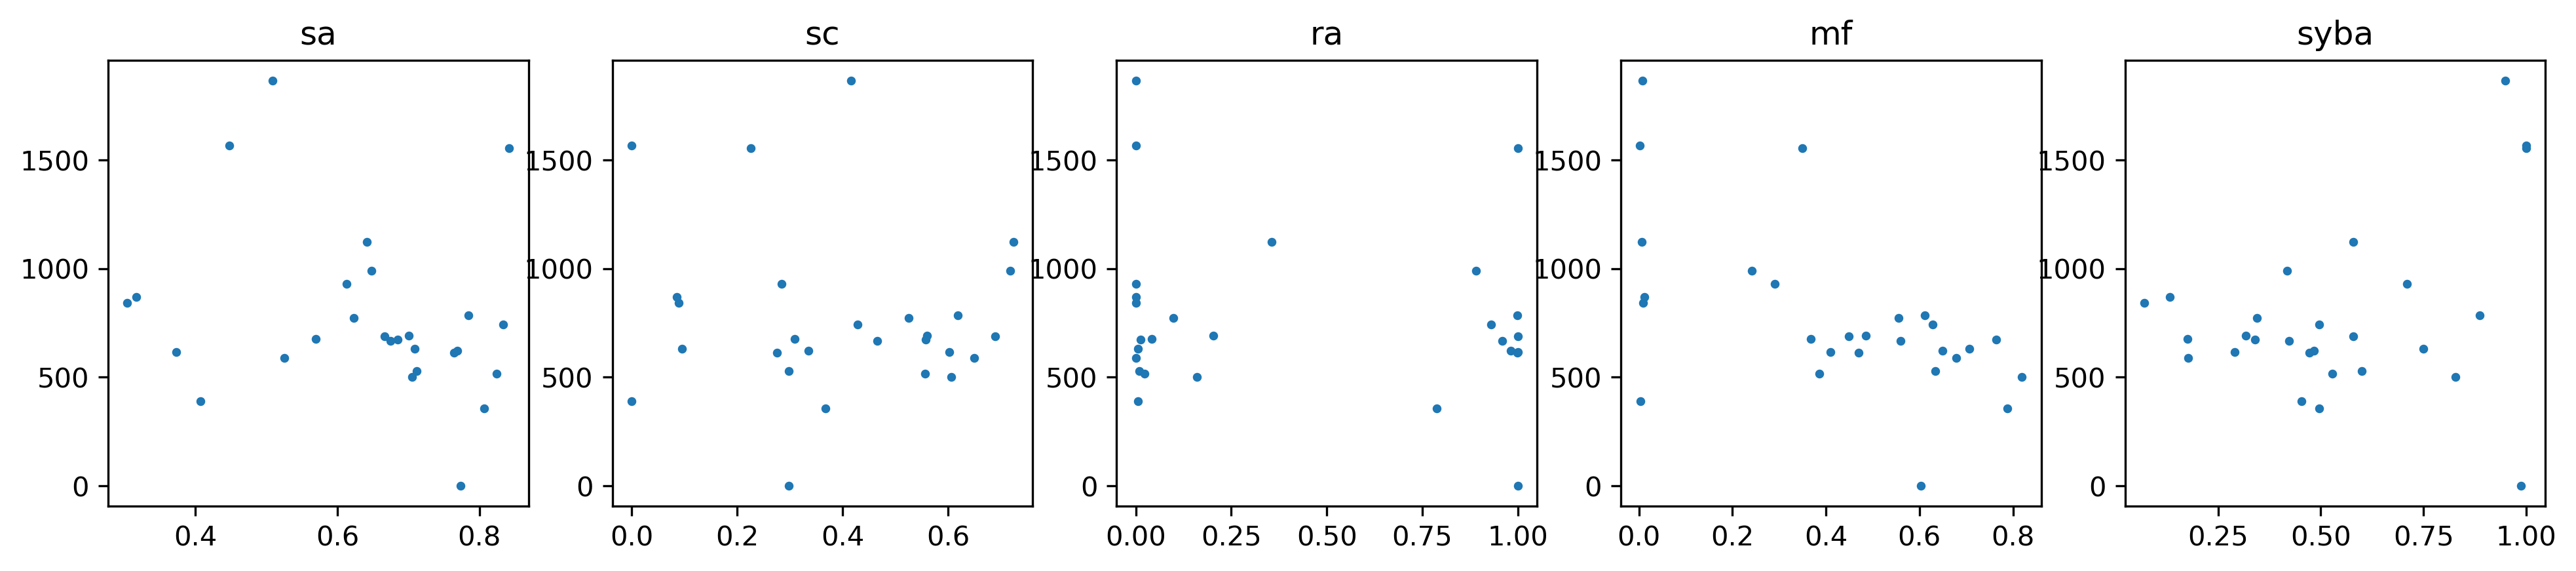

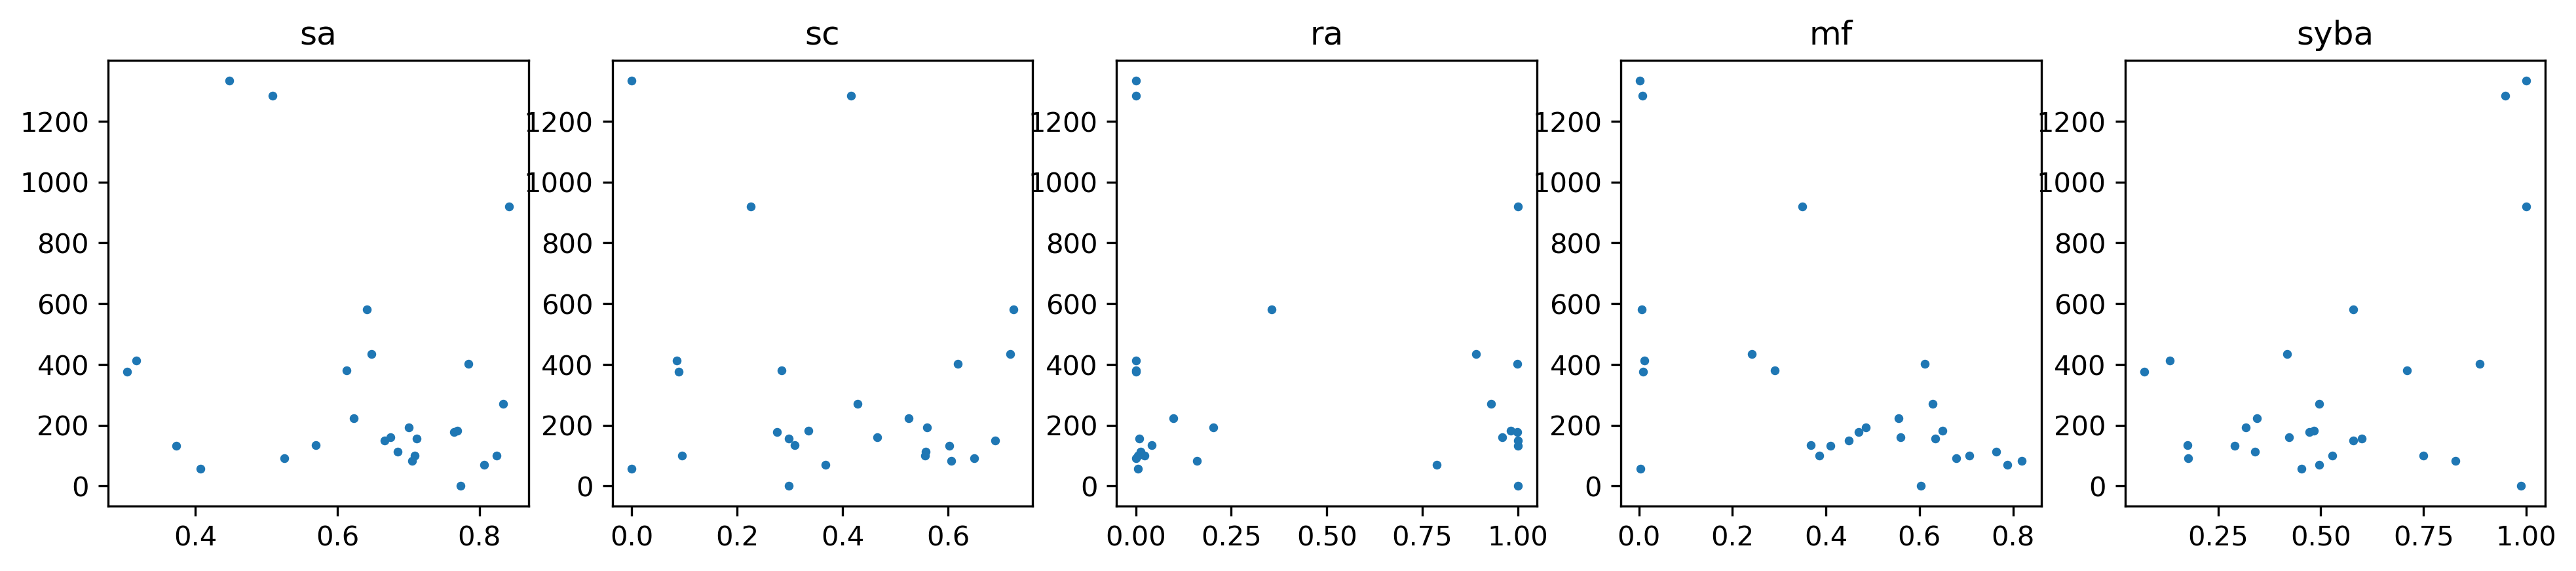

In [13]:

with Db("db_modified", True) as db:
    mols = data()
    tree_stats = [get_stats(mol) for mol in mols]
    for filter in filters:
        display(HTML("============================================="))
        display(HTML("filter: " + fn_txt(filter)))
        for characteristic in ("max_depth", "max_width", "node_count", "not_solved_count"):
            display(HTML(characteristic))
            rows: list[tuple[str, float,float,float]] = []
            pairs_score_characteristic: list[tuple[Score, int]] = [(score, stats[characteristic]) for score, type, stats in tree_stats if filter(type)]
            pairs_per_plot = []
            for score_name, getter in Score.getters():
#                 display(HTML(score_name))
                pairs_per_plot.append([(score_transformer(getter(score), score_name),
                                        char_value, score_name) for score, char_value in pairs_score_characteristic])
            scatter_plot(pairs_per_plot)

In [14]:
# Same as above with Spearman corr.

%load_ext autoreload
%autoreload 2

%matplotlib inline

from shared import Db, Fn

from main.ai import ai_setups, zero_setup
from main.data import Mol, data
from main.tree import JsonTree, Tree, TreeTypes
from main.types import AiInput, Setup
from main.score import Score

from IPython.display import display, HTML
from typing import Any

from scipy.stats import spearmanr

import numpy as np
import pandas
from main.utils import fn_txt


import matplotlib.pyplot as plt



def corr_row(pairs_per_plot: list[list[tuple[Any, Any, str]]]):
    result1 = []; result2 = []
    for i, pairs in enumerate(pairs_per_plot):
        xs = [x for x, _y, in pairs]
        ys = [y for _x, y, in pairs]
        corr = spearmanr(xs, ys, alternative="less")
        result1.append(corr.correlation)
        result2.append(corr.pvalue)
    return result1, result2


def get_stats(mol: Mol):
    ai_input: AiInput = {"smiles": mol.smiles, "setup": zero_setup}
    json_tree = db.read(["ai_postprocess", ai_input], JsonTree)
    assert json_tree
    tree = Tree(json_tree)
    assert len(tree.expandable) == 1
    assert len(tree.in_stock) == 0
    return tree.expandable[0].score, tree.type, tree.stats()

# filters: list[Fn[TreeTypes, bool]] = [
#     lambda _type: True,
#     lambda type: type == "internal",
#     lambda type: type == "not_solved"
# ]
filters: list[Fn[TreeTypes, bool]] = [
    lambda _type: True # for data dump we are only interested in this type data
]


names = []
characteristics = []
vals = []
pvals = []

with Db("db_modified", True) as db:
    mols = data()
    tree_stats = [get_stats(mol) for mol in mols]
    for filter in filters:
        rows = [[""]]
        title = False
        display(HTML("============================================="))
        display(HTML("filter: " + fn_txt(filter)))
        for characteristic in (#"max_depth", 
                "max_width", "node_count", "not_solved_count"):
#             display(HTML(characteristic))
            pairs_score_characteristic: list[tuple[Score, int]] = [(score, stats[characteristic]) for score, type, stats in tree_stats if filter(type)]
            pairs_per_plot = []
            for score_name, getter in Score.getters():
                if not (score_name == "mf" and not USE_MF):
                    if not title: rows[0].append(score_name)
                    pairs_per_plot.append([(score_transformer(getter(score), score_name),
                                            char_value) for score, char_value in pairs_score_characteristic])

            title = True
            first_row, second_row = corr_row(pairs_per_plot)
            rows.append([characteristic] + first_row)
            rows.append([""] + second_row)
            names.extend([sn for sn, _ in Score.getters() if not (sn == "mf" and not USE_MF)])
            characteristics.extend([characteristic] * len(first_row))
            vals.extend(first_row)
            pvals.extend(second_row)
        tab = tabulate.tabulate(rows, headers="firstrow",tablefmt='html')
        display(tab)
        break
        
        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,sa,sc,ra,mf,syba
max_width,-0.319733,-0.254357,-0.338256,-0.288806,-0.0556094
,0.0125618,0.0388938,0.00872211,0.0220804,0.352154
node_count,-0.45241,-0.246231,-0.429732,-0.335264,-0.139256
,0.000549918,0.0440516,0.00102972,0.00926473,0.169969
not_solved_count,-0.394081,-0.25988,-0.379634,-0.327848,-0.141873
,0.00254159,0.0356687,0.0035686,0.0107339,0.165425


In [15]:
import pandas as pd

df = pd.DataFrame(zip(names, characteristics, vals, pvals))
df.to_csv("results/table_roots_mf.csv")


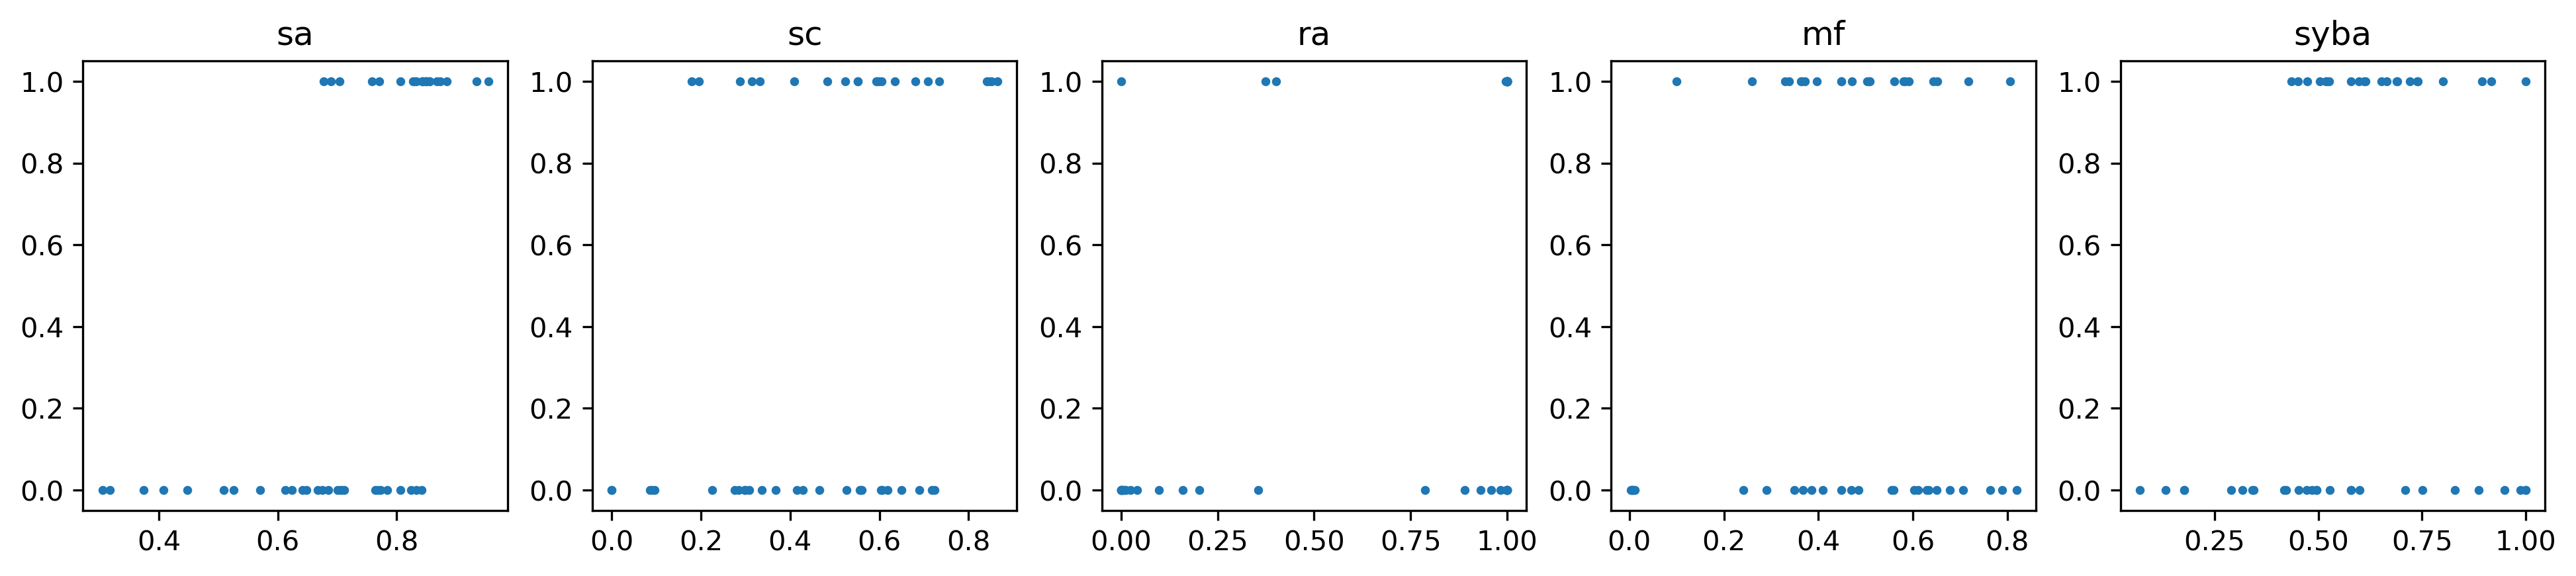

In [16]:
# The same but also checked just result of synthesis


with Db("db_modified", True) as db:
    mols = data()
    tree_stats = [get_stats(mol) for mol in mols]

    rows: list[tuple[str, float,float,float]] = []
    pairs_score_characteristic: list[tuple[Score, int]] = [(score, 
                                                            1 if type in ["internal", "solved"] else 0) for score, type, stats in tree_stats]
    pairs_per_plot = []
    for score_name, getter in Score.getters():

        pairs_per_plot.append([(score_transformer(getter(score), score_name),
                                char_value, score_name) for score, char_value in pairs_score_characteristic])
    scatter_plot(pairs_per_plot)

In [17]:
name_mapping = {"sa": "SAscore", "sc": "SCScore", "ra": "RAscore", "syba": "SYBA", "mf": "OC-MF-Score"}

For sa, best Threshold=0.806595, G-Mean=0.829
sa AUC 0.9006734006734007
Accuracy: 0.8163265306122448
For sc, best Threshold=0.483849, G-Mean=0.656
sc AUC 0.6851851851851851
Accuracy: 0.6326530612244898
For ra, best Threshold=0.999568, G-Mean=0.835
ra AUC 0.8468013468013469
Accuracy: 0.8163265306122448
For mf, best Threshold=0.471107, G-Mean=0.532
mf AUC 0.5252525252525253
Accuracy: 0.510204081632653
For syba, best Threshold=0.503601, G-Mean=0.693
syba AUC 0.6616161616161617
Accuracy: 0.673469387755102


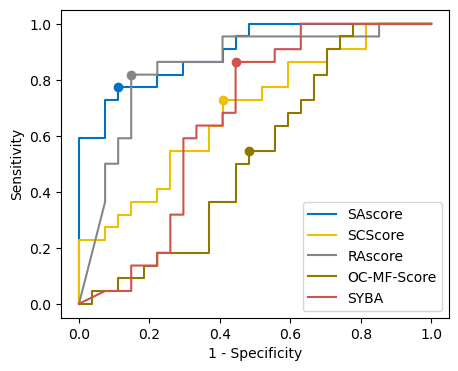

In [23]:
# ROC of the same as above

colors = {"sa": "#0073C2", "sc": "#EFC000", "ra": "#868686", "syba": "#CD534C", "mf":"#8F7700"}


# ground truth - result of AiZynthFinder
# prediction - sa scores
with plt.style.context("default"):

    fig = plt.figure(figsize=(5, 4))
#     fig.set_dpi(300)

    with Db("db_modified", True) as db:
        mols = data()
        tree_stats = [get_stats(mol) for mol in mols]

        gt = np.array([1 if type in ["internal", "solved"] else 0 for _, type, _ in tree_stats])
        shitty_convoluted_scores = [score for score, _, _ in tree_stats]
        predictions = []
        for score_name, getter in Score.getters():
            if not (score_name == "mf" and not USE_MF):
                single_score_predictions = [score_transformer(getter(score), score_name) for score in shitty_convoluted_scores]
                fpr, tpr, thresholds = metrics.roc_curve(gt, single_score_predictions)
                gmeans = np.sqrt(tpr * (1-fpr))
                ix = np.argmax(gmeans)
                print('For %s, best Threshold=%f, G-Mean=%.3f' % (score_name, thresholds[ix], gmeans[ix]))

                print(score_name, "AUC", metrics.auc(fpr, tpr))
                
                synthetis_predicted = single_score_predictions > thresholds[ix]
                synthesis_found = np.array([ts[1] in ["solved", "internal"] for ts in tree_stats])
                correctly_found = np.logical_and(synthesis_found, synthetis_predicted)
                correctly_not_found = np.logical_and(np.logical_not(synthetis_predicted),
                                                     np.logical_not(synthesis_found))
                print("Accuracy:", np.sum(np.logical_or(correctly_found, correctly_not_found) / len(tree_stats)))
                plt.plot(fpr,tpr, label=name_mapping[score_name], color=colors[score_name])
                plt.scatter(fpr[ix], tpr[ix], marker='o', color=colors[score_name])
                plt.ylabel("Sensitivity")
                plt.xlabel("1 - Specificity")

            predictions.append(single_score_predictions)
    plt.legend()        
#     plt.show()
plt.savefig("figures/roc.pdf")

<Figure size 432x288 with 0 Axes>